# Tutorial 3: Running Quantization-Aware Training (QAT) on Bert

In this tutorial, we'll build on top of Tutorial 2 by taking the Bert model fine tuned for sequence classification and running Mase's quantization pass. First, we'll run simple Post-Training Quantization (PTQ) and see how much accuracy drops. Then, we'll run some further training iterations of the quantized model (i.e. QAT) and see whether the accuracy of the trained quantized model approaches the accuracy of the original (full-precision) model.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [2]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new 

If you have previously ran the tutorial on LoRA Finetuning, run the following cell to import the fine tuned checkpoint.

In [ ]:
from pathlib import Path
from chop import MaseGraph

lab0_out_dir = Path("/workspace/labs/lab0/outputs")
lab1_out_dir = Path("/workspace/labs/lab1/outputs")
lab1_out_dir.mkdir(parents=True, exist_ok=True)

mg = MaseGraph.from_checkpoint(f"{lab0_out_dir}/tutorial_2_lora")

/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.


## Post-Training Quantization (PTQ)

Here, we simply quantize the model and evaluate the effect in its accuracy. First, let's evaluate the model accuracy before quantization (if you're coming from Tutorial 2, this should be the same as the post-LoRA evaluation accuracy). As seen in Tutorial 2, we can use the `get_tokenized_dataset` and `get_trainer` utilities to generate a HuggingFace `Trainer` instance for training and evaluation.

In [3]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Map: 100%|██████████| 50000/50000 [00:10<00:00, 4641.88 examples/s]
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83488


To run the quantization pass, we pass a quantization configuration dictionary as argument. This defines the quantization mode, numerical format and precision for each operator in the graph. We'll run the quantization in "by type" mode, meaning nodes are quantized according to their `mase_op`. Other modes include by name and by regex name. We'll quantize all activations, weights and biases in the model to fixed-point with the same precision. This may be sub-optimal, but works as an example. In future tutorials, we'll see how to run the `search` flow in `Mase` to find optimal quantization configurations to minimize accuracy loss.

In [4]:
import chop.passes as passes

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

mg, _ = passes.quantize_transform_pass(
    mg,
    pass_args=quantization_config,
)

Let's evaluate the immediate effect of quantization on the model accuracy.

In [5]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.7494


We can save the current checkpoint for future reference (optional).

In [6]:
from pathlib import Path

mg.export(f"{lab1_out_dir}/tutorial_3_ptq")

INFO     Exporting MaseGraph to /workspace/labs/lab1/outputs/tutorial_3_ptq.pt, /workspace/labs/lab1/outputs/tutorial_3_ptq.mz
INFO     Exporting GraphModule to /workspace/labs/lab1/outputs/tutorial_3_ptq.pt
INFO     Saving full model format
INFO     Exporting MaseMetadata to /workspace/labs/lab1/outputs/tutorial_3_ptq.mz


## Quantization-Aware Training (QAT)

You should have seen in the last section that quantization can lead to a significant drop in accuracy. Next, we'll run QAT to evaluate whether this performance gap can be reduced. To run QAT in Mase, all you need to do is include the model back in your training loop after running the quantization pass.

In [7]:
# Evaluate accuracy
trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Step,Training Loss
500,0.405700
1000,0.394500
1500,0.405700
2000,0.387800
2500,0.388400
3000,0.388200


Evaluation accuracy: 0.83856


We can see the accuracy of the quantized model can match (or sometimes exceed) the full precision model, with a much lower memory requirement to store the weights. Finally, save the final checkpoint for future tutorials.

In [8]:
from pathlib import Path

mg.export(f"{lab1_out_dir}/tutorial_3_qat")

INFO     Exporting MaseGraph to /workspace/labs/lab1/outputs/tutorial_3_qat.pt, /workspace/labs/lab1/outputs/tutorial_3_qat.mz
INFO     Exporting GraphModule to /workspace/labs/lab1/outputs/tutorial_3_qat.pt
INFO     Saving full model format
INFO     Exporting MaseMetadata to /workspace/labs/lab1/outputs/tutorial_3_qat.mz


## Implementation Tasks
### 1. Config Generator

In [38]:
def make_quantization_config(w: int):
    frac_width = max(4, w-2)
    return {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": w,
                "data_in_frac_width": frac_width,
                # weight
                "weight_width": w,
                "weight_frac_width": frac_width,
                # bias
                "bias_width": w,
                "bias_frac_width": frac_width,
            }
        },
    }

In [32]:
n = 5
widths = [2**i for i in range (2,n+1) ]


In [39]:
from chop import MaseGraph
from pathlib import Path
from chop.passes import quantize_transform_pass
from chop.tools import get_trainer, get_tokenized_dataset, get_logger

logger = get_logger("mase_logger")
logger.setLevel("INFO")


lab0_out_dir = Path("/workspace/labs/lab0/outputs")
lab1_out_dir = Path("/workspace/labs/lab1/outputs")
lab1_out_dir.mkdir(parents=True, exist_ok=True)

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)



def run_quantization_experiment(widths: list, quant_type = "ptq"):
    results = {}
    for w in widths:
        logger.info(f"Running experiment with width: {w}")
        quantization_config = make_quantization_config(w)
        mg = MaseGraph.from_checkpoint(f"{lab0_out_dir}/tutorial_2_lora")
        mg_quant, _ = quantize_transform_pass(
            mg,
            pass_args=quantization_config,
        )

        trainer_quant = get_trainer(
            model=mg_quant.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
        )

        if quant_type == "qat":
            trainer_quant.train()

        eval_results = trainer_quant.evaluate()
        accuracy = eval_results["eval_accuracy"]
        logger.info(f"Width: {w}, Accuracy: {accuracy}")
        results[w] = accuracy
    return results

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [40]:
ptq_results = run_quantization_experiment(widths, quant_type="ptq")
qat_results = run_quantization_experiment(widths, quant_type="qat")

INFO     Running experiment with width: 4
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


INFO     Width: 4, Accuracy: 0.67572
INFO     Running experiment with width: 8
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


INFO     Width: 8, Accuracy: 0.81092
INFO     Running experiment with width: 16
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


INFO     Width: 16, Accuracy: 0.81508
INFO     Running experiment with width: 32
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


INFO     Width: 32, Accuracy: 0.8152
INFO     Running experiment with width: 4
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.614400
1000,0.542400
1500,0.496900
2000,0.470900
2500,0.473200
3000,0.480800


INFO     Width: 4, Accuracy: 0.79256
INFO     Running experiment with width: 8
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.416200
1000,0.402800
1500,0.407700
2000,0.389600
2500,0.386900
3000,0.395300


INFO     Width: 8, Accuracy: 0.838
INFO     Running experiment with width: 16
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.415500
1000,0.401100
1500,0.407800
2000,0.389000
2500,0.385100
3000,0.395100


INFO     Width: 16, Accuracy: 0.83764
INFO     Running experiment with width: 32
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.415600
1000,0.401100
1500,0.407900
2000,0.389000
2500,0.385100
3000,0.395100


INFO     Width: 32, Accuracy: 0.83776


In [41]:
def plot_quantization_results(results_ptq: dict, results_qat: dict):
    import matplotlib.pyplot as plt

    widths_ptq = list(results_ptq.keys())
    accuracies_ptq = list(results_ptq.values())

    widths_qat = list(results_qat.keys())
    accuracies_qat = list(results_qat.values())

    plt.figure(figsize=(10, 6))
    plt.plot(widths_ptq, accuracies_ptq, marker='o', label='PTQ', color='blue')
    plt.plot(widths_qat, accuracies_qat, marker='o', label='QAT', color='orange')
    plt.xscale('log', base=2)
    plt.xlabel('Quantization Width (bits)')
    plt.ylabel('Evaluation Accuracy')
    plt.title('Quantization Width vs Evaluation Accuracy')
    plt.xticks(widths_ptq, labels=widths_ptq)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{lab1_out_dir}/quantization_results.png")
    plt.show()
    

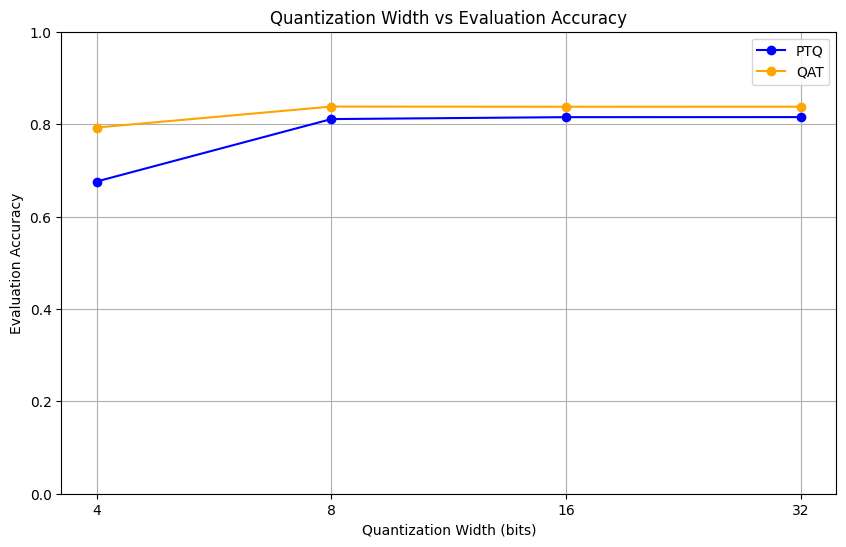

In [42]:
plot_quantization_results(ptq_results, qat_results)